# An Odyssey Into "Interesting" Data

I can say without a doubt, it was very fun analyzing the dataset given to me. I also applied math I haven't used in a while! I hope you have as much fun reading about my escapades into the intriguing dataset! 

We'll start by importing the required libraries.

In [1]:
import pandas as pd
import glob
import math
from statistics import mean
import copy
import sklearn
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate, KFold, train_test_split
from sklearn.metrics import make_scorer, accuracy_score, f1_score, roc_auc_score, precision_score, recall_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

## Required Helper Functions
I implement some basic functions to help with calculating the changes in heading below.

In [2]:
#Distance formula to get the distance between two points.
def distFormula(coord1, coord2):
    return math.sqrt(math.pow(coord2[0]-coord1[0],2) + math.pow(coord2[1]-coord1[1], 2))

#Converts a heading in degrees to a unit vector to handle cases where a vehicle might go from 350 to 4 degrees for example.
def unitVectorize(heading):
    return((math.cos(math.radians(heading)), math.sin(math.radians(heading))))

#Determines whether or not the headings make up a turn.
def isTurn(heading1, heading2):
    if distFormula(heading1, heading2) >= 1:
        return True
    return False

## Getting the stops and features across all files
I examined the data in 0000.csv and defined a stop as an event which has a speed less than .05 and is not adjacent to another previous event with a similar speed. Then I defined a turn as a series of events in which the average acceleration is great than or less than .086. I chose this number based on the instaneous acceleration between two initial headings of the first "turn". 

I also converted headings to unit vectors to make it easier to work with. As a turn qualifies as a change of 60 degrees or greater, that equates to the distance between two headings to be greater or equal than 1. 

For each row, I check to see whether or not we have an event that takes up 3 seconds. If we don't, we'll note our speed and heading. Otherwise, if three seconds have passed between our record and the beginning record, we'll see whether or not we found a stop or a turn based on our records stored so far. If our events don't comprise three seconds and we find a record beyond the range of three seconds, we'll discard our records. Turns can be made up of multiple 3 second events and we will only evaulate the turn if the average acceleration is lower than a threshold.


In [4]:
def getStops(currSpeed, pastSpeeds, prevEventIsStop, numStops):
    pastSpeeds.append(currSpeed)
    foundStopEvent = False
    if mean(pastSpeeds) < 1 and prevEventIsStop == False:        
        foundStopEvent = True
        prevEventIsStop = True
    if foundStopEvent:
        numStops += 1
    else:
        prevEventIsStop = False
    return (numStops, prevEventIsStop)

def getTurns(currHeadingVector, eventOf3Secs, timeDelta, possibleTurn, possibleTurnEvents, turns):
    eventOf3Secs.append(currHeadingVector)
    average_accel = distFormula(eventOf3Secs[0], currHeadingVector)/(timeDelta )
    if average_accel >= .086:
        possibleTurn = True
        possibleTurnEvents.append(eventOf3Secs)
    #if avg acceleration has slowed down and past recent events were above the threshold see if it's a turn
    elif possibleTurn:
        minHeading = possibleTurnEvents[0][0]
        maxHeading = currHeadingVector
        if isTurn(minHeading, maxHeading):
            turns += 1
        possibleTurn = False
        possibleTurnEvents.clear()
    return (turns, possibleTurn)

def getStopsAndTurns(data):
    data['time_seconds'] = data['time_seconds'].astype(float).round(2)
    stops = 0
    turns = 0
    eventTimeStart = 0
    eventStarted = False
    #stop logic specific
    pastSpeeds = []
    prevEventIsStop = False

    #turn logic specific
    possibleTurnEvents = []
    eventOf3Secs = []
    possibleTurn = False
    
    for index, row in data.iterrows():
        if not eventStarted:
            eventStarted = True
            eventTimeStart = row[0]
            pastSpeeds.append(row[1])
            eventOf3Secs.append(unitVectorize(row[2]))
        else:
            currTime = row[0]
            timeDelta = currTime - eventTimeStart
            currHeading = unitVectorize(row[2])
            if timeDelta < 3:
                pastSpeeds.append(row[1])
                eventOf3Secs.append(currHeading)
                continue
            elif timeDelta == 3:
                stops, prevEventIsStop = getStops(row[1], pastSpeeds, prevEventIsStop, stops)
                turns, possibleTurn = getTurns(currHeading, eventOf3Secs, timeDelta, possibleTurn, possibleTurnEvents, turns)
                eventOf3Secs = []
                pastSpeeds = []
                eventStarted = False
            else:
                pastSpeeds = []
                eventOf3Secs = []
                eventTimeStart = row[0]
                pastSpeeds.append(row[1])
                eventOf3Secs.append(currHeading)
    return(stops, turns)

## Cleaning up the Data

Any data scientist will tell you that a model is only as good as the data given to it. So it stands to reason that one needs to clean the data for processing. Let's do that in the below section! We'll get rid of any row that contains NAN's as I consider incomplete data to be flawed. For example, I noticed a lot of NaN's in heading degrees in several files. This could skew the data towards a false narrative so I decided it was best to just toss those rows out. Below I clean up the data and calculate the stops and turns in each file.


In [6]:
localdirRoot = '/home/aaron/Documents/Coding/RootDataScienceWork/'
trainingFiles = sorted(glob.glob(localdirRoot + 'work_sample/trip_data_train/trip_data/' + "/*.csv"))
dataFrames = [pd.read_csv(file) for file in trainingFiles]
stopsTurns = [(0,0) for i in range(len(trainingFiles))]
index = 0
t = False
for df in dataFrames:
    df.dropna(how='any', inplace=True)
    stops, turns = getStopsAndTurns(df)
    stopsTurns[index] = (stops, turns)
    index += 1

# Evaluating Models


## Training Models With no Extra Features

Here I decided to see how the models would perform without adding any extra features and plain cross validation. This allowed me to pick which one I want to use as my primary classifier. It would appear SVM is the way to go based on initial runs.


In [7]:
trainingFeaturesDF = pd.read_csv("./model_data_train.csv")
y = trainingFeaturesDF.iloc[:,-1]

In [8]:
trainingFeaturesDF = trainingFeaturesDF.drop(columns=['y'])
X = trainingFeaturesDF.iloc[:,1:]
mms = MinMaxScaler()
trainingFeaturesDF['Stops'] = [stop[0] for stop in stopsTurns]
trainingFeaturesDF['Turns'] = [turn[1] for turn in stopsTurns]

We create three datasets for stops and turns, stops, and turns.

In [9]:
print("X: ", X)
XwithStopsandTurns = trainingFeaturesDF.iloc[:, 1:]
print("X with stops and turns: ", XwithStopsandTurns)
XwithStops = trainingFeaturesDF.iloc[:, 1:-1]
print("X with stops: ", XwithStops)
XwithTurns = trainingFeaturesDF.iloc[:, 1:-2]
XwithTurns['Turns'] = trainingFeaturesDF['Turns']
print("X with turns: ", XwithTurns)

X:       feature1  feature2  feature3  feature4      feature5      feature6  \
0       False     False      True  5.209096   9789.261511  30753.872048   
1       False     False     False  4.450941  10552.521899  33151.725274   
2       False     False      True  5.396552  10233.433119  32149.278307   
3       False     False      True  4.970163  10829.056746  34020.485118   
4       False     False     False  5.266868  10678.703687  33548.137053   
..        ...       ...       ...       ...           ...           ...   
995     False     False     False  5.557740  11792.408911  37046.945203   
996     False     False      True  6.159746  10144.628262  31870.289621   
997     False     False     False  5.903515  11274.898280  35421.137606   
998     False     False     False  4.196761   8774.186650  27564.920320   
999     False     False     False  4.061768   9346.232951  29362.056777   

     feature7  feature8  feature9  feature10     feature11    feature12  \
0    0.001010       

## Normalizing Data
We need to normalize the data so that select features such as feature 13 don't skew our training too much

In [10]:
X = mms.fit_transform(X)
XwithStopsandTurns = mms.fit_transform(XwithStopsandTurns)
XwithStops = mms.fit_transform(XwithStops)
XwithTurns = mms.fit_transform(XwithTurns)

print("X: ", X)
print("X with stops and turns: ", XwithStopsandTurns)
print("X with stops: ", XwithStops)
print("X with turns: ", XwithTurns)

X:  [[0.00000000e+00 0.00000000e+00 1.00000000e+00 ... 2.02222107e-07
  1.54454722e-08 4.36602252e-01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.41802183e-06
  7.00473091e-08 2.44797346e-01]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00 ... 2.17917192e-05
  2.15056850e-05 5.69468235e-01]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 6.15734522e-05
  8.47227075e-03 5.44856313e-01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 9.15356581e-04
  4.86464614e-08 4.43918905e-01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.83817625e-04
  2.27542170e-08 4.47720036e-01]]
X with stops and turns:  [[0.         0.         1.         ... 0.43660225 0.         0.14285714]
 [0.         0.         0.         ... 0.24479735 0.01492537 0.57142857]
 [0.         0.         1.         ... 0.56946823 0.         0.28571429]
 ...
 [0.         0.         0.         ... 0.54485631 0.46268657 0.28571429]
 [0.         0.         0.         ... 0.4439189  0.10447761 0.57142857]
 

In [11]:

def oob_(estimator, X, y):
    return 1 - estimator.oob_score_
def accuracy(y_true, y_pred):
    return accuracy_score(y_true, y_pred)
def f1(y_true, y_pred):
    return f1_score(y_true, y_pred)
def auc(y_true, y_pred):
    return roc_auc_score(y_true, y_pred)
def precision(y_true, y_pred):
    return precision_score(y_true, y_pred)
def recall(y_true, y_pred):
    return recall_score(y_true, y_pred)

scoringRandomForest = {
    'oob': oob_,
    'accuracy': make_scorer(accuracy),
    'precision': make_scorer(precision),
    'recall': make_scorer(recall),
    'f1 score': make_scorer(f1),
    'roc auc': make_scorer(auc)
}
scoring2 = {
    'accuracy': make_scorer(accuracy),
    'precision': make_scorer(precision),
    'recall': make_scorer(recall),
    'f1 score': make_scorer(f1),
    'roc auc': make_scorer(auc)
}

#t = training v = validation (for testing) y's are the lables for each respective set
Xt, Xv, yt, yv = train_test_split(X, y, test_size=0.3)
fold = KFold(n_splits=3)

## Evaluating Models 
Here we'll evaluate different classifiers for use with the dataset given to us with no additional features. They are: Random Forest, Decision Tree, Support Vector Machines, Logistic Regression, and K-Nearest Neighbors. We'll train them, print out a sample results run that will give us a window into some of the metrics behind the predictions. Then we cross validate them by splitting them into 3 subsets of data and evaluate the results as well as print them in a visual dataframe. 

Feel free to skim some of the sections or skip to the end for what I've concluded. I show my work in analyzing the best model for making predictions against the test data in the below sections.

In [12]:
def printScoresInSampleRun(testlabels, predictions, classifier, testData):
    print('Accuracy Score :', np.round(accuracy_score(testlabels, predictions), 4))
    print('Precision Score :', np.round(precision(testlabels, predictions), 4))
    print('Recall Score :', np.round(recall_score(testlabels, predictions), 4))
    print('F1 Score :', np.round(f1_score(testlabels, predictions), 4))
    print('AUC Score :', np.round(roc_auc_score(testlabels, classifier.predict_proba(testData)[:,1]), 4))

### Models Without Stops and Turns

#### Random Forest
We see the results of a run with the random forest classifier. I thought it might be useful to include the OOB error as well as an additional metric. 

In [13]:
randomForestClassifier = RandomForestClassifier(oob_score=True)
randomForestClassifier.fit(Xt, yt)
randomForestPred = randomForestClassifier.predict(Xv)
printScoresInSampleRun(yv, randomForestPred, randomForestClassifier, Xv)
print('OOB Error :', np.round(1 - randomForestClassifier.oob_score_, 4))

cvRandomForest = cross_validate(RandomForestClassifier(oob_score=True), X, y, scoring=scoringRandomForest, cv=fold)

cvRandomForest_result = pd.DataFrame({
    'Model': 'RandomForestClassifier',
    'Accuracy': np.round(cvRandomForest['test_accuracy'].mean(), 4),
    'Precision': np.round(cvRandomForest['test_precision'].mean(), 4),
    'Recall': np.round(cvRandomForest['test_recall'].mean(), 4),
    'F1 Score': np.round(cvRandomForest['test_f1 score'].mean(), 4),
    'ROC AUC': np.round(cvRandomForest['test_roc auc'].mean(), 4),
    'OOB Error': np.round(cvRandomForest['test_oob'].mean(), 4)
},index=[0])
cvRandomForest_result

Accuracy Score : 0.8467
Precision Score : 0.8333
Recall Score : 0.6111
F1 Score : 0.7051
AUC Score : 0.9045
OOB Error : 0.1786


,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC,OOB Error
0,RandomForestClassifier,0.85,0.8325,0.6525,0.7279,0.7958,0.1725


#### Decision Trees
Here we see the results of the decision trees classifier. I created a different scoring object for non random forest classifiers. The results are considerably lower than the other classifiers.

In [14]:
decisionTreesClassifier = DecisionTreeClassifier()
decisionTreesClassifier.fit(Xt, yt)
decisionTreesPred = decisionTreesClassifier.predict(Xv)

printScoresInSampleRun(yv, decisionTreesPred, decisionTreesClassifier, Xv)
cvDecisionTrees = cross_validate(DecisionTreeClassifier(), X, y, scoring=scoring2, cv=fold)

cvDecisionTrees_result = pd.DataFrame({
    'Model': 'Decision Tree',
    'Accuracy': np.round(cvDecisionTrees['test_accuracy'].mean(), 4),
    'Precision': np.round(cvDecisionTrees['test_precision'].mean(), 4),
    'Recall': np.round(cvDecisionTrees['test_recall'].mean(), 4),
    'F1 Score': np.round(cvDecisionTrees['test_f1 score'].mean(), 4),
    'ROC AUC': np.round(cvDecisionTrees['test_roc auc'].mean(), 4)
},index=[0])
cvDecisionTrees_result

Accuracy Score : 0.8033
Precision Score : 0.6566
Recall Score : 0.7222
F1 Score : 0.6878
AUC Score : 0.7802


,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,Decision Tree,0.781,0.6671,0.5881,0.6247,0.728


#### Support Vector Machines
Here we see the results of the SVM's classifer

In [15]:
supportVectorClassifier = svm.SVC(probability=True)
supportVectorClassifier.fit(Xt, yt)
svmPredictions = supportVectorClassifier.predict(Xv)

printScoresInSampleRun(yv, svmPredictions, supportVectorClassifier, Xv)

cvSVM = cross_validate(svm.SVC(), X, y, scoring=scoring2, cv=fold)
cvSVM_result = pd.DataFrame({
    'Model': 'SVM',
    'Accuracy': np.round(cvSVM['test_accuracy'].mean(), 4),
    'Precision': np.round(cvSVM['test_precision'].mean(), 4),
    'Recall': np.round(cvSVM['test_recall'].mean(), 4),
    'F1 Score': np.round(cvSVM['test_f1 score'].mean(), 4),
    'ROC AUC': np.round(cvSVM['test_roc auc'].mean(), 4)
},index=[0])
cvSVM_result

Accuracy Score : 0.88
Precision Score : 0.8462
Recall Score : 0.7333
F1 Score : 0.7857
AUC Score : 0.9303


,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,SVM,0.855,0.8089,0.7123,0.752,0.8163


#### Logistic Regression
Here we see the results of the logistic regression classifier.

In [16]:
logisticRegressionClassifier = LogisticRegression().fit(Xt,yt)
lrcPredictions = logisticRegressionClassifier.predict(Xv)

printScoresInSampleRun(yv, lrcPredictions, logisticRegressionClassifier, Xv)

cvLRC = cross_validate(LogisticRegression(), X, y, scoring=scoring2, cv=fold)
cvLRC_result = pd.DataFrame({
    'Model': 'Logistic Regression',
    'Accuracy': np.round(cvLRC['test_accuracy'].mean(), 4),
    'Precision': np.round(cvLRC['test_precision'].mean(), 4),
    'Recall': np.round(cvLRC['test_recall'].mean(), 4),
    'F1 Score': np.round(cvLRC['test_f1 score'].mean(), 4),
    'ROC AUC': np.round(cvLRC['test_roc auc'].mean(), 4)
},index=[0])
cvLRC_result

Accuracy Score : 0.88
Precision Score : 0.8857
Recall Score : 0.6889
F1 Score : 0.775
AUC Score : 0.9326


,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,Logistic Regression,0.856,0.8626,0.6503,0.736,0.7998


#### K-Nearest Neighbors
Here we see the results of the k-nearest neighbors classifier.

In [17]:
kNeighborsClassifier = KNeighborsClassifier().fit(Xt,yt)
kNPredictions = kNeighborsClassifier.predict(Xv)

printScoresInSampleRun(yv, kNPredictions, kNeighborsClassifier, Xv)

cvkN = cross_validate(KNeighborsClassifier(), X, y, scoring=scoring2, cv=fold)
cvkN_result = pd.DataFrame({
    'Model': 'K Neighbors',
    'Accuracy': np.round(cvkN['test_accuracy'].mean(), 4),
    'Precision': np.round(cvkN['test_precision'].mean(), 4),
    'Recall': np.round(cvkN['test_recall'].mean(), 4),
    'F1 Score': np.round(cvkN['test_f1 score'].mean(), 4),
    'ROC AUC': np.round(cvkN['test_roc auc'].mean(), 4)
},index=[0])
cvkN_result

Accuracy Score : 0.83
Precision Score : 0.7241
Recall Score : 0.7
F1 Score : 0.7119
AUC Score : 0.8743


,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,K Neighbors,0.82,0.7481,0.6419,0.6887,0.7716


### Evaluating the Metrics Across the Dataset Without Additional Features
Let's plot the accuracy, precision, and recall scores across the different classifiers!

#### Accuracy 
Let's take a look at the accuracies across the classifiers.

Text(0.5, 0.98, 'Accuracies of Classifiers')

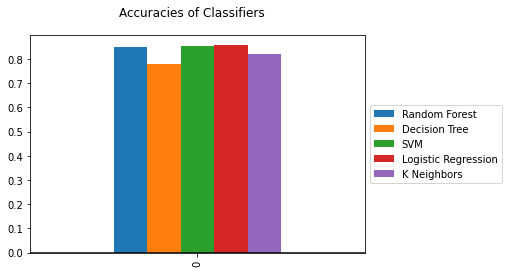

In [18]:
accuracyFrame = pd.DataFrame({
    'Random Forest': cvRandomForest_result["Accuracy"],
    'Decision Tree': cvDecisionTrees_result["Accuracy"],
    'SVM': cvSVM_result["Accuracy"],
    'Logistic Regression': cvLRC_result['Accuracy'],
    'K Neighbors': cvkN_result['Accuracy']
},index=[0])

accuracyFrame.plot(kind='bar')
plt.axhline(0, color='k')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.suptitle('Accuracies of Classifiers')

We can see that there are three top candidates for our optimal classifier with logistic regression slightly leading but I'll give K neighbors the benefit of the doubt.

#### Precision
Let's take a look at the precision across the different classifiers.

Text(0.5, 0.98, 'Precision of Classifiers')

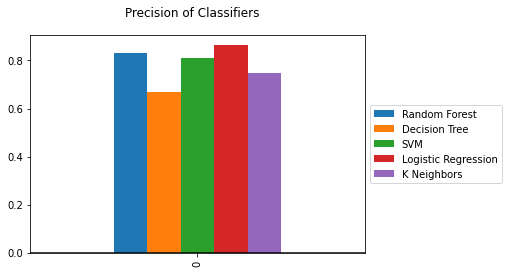

In [19]:
precisionFrame = pd.DataFrame({
    'Random Forest': cvRandomForest_result["Precision"],
    'Decision Tree': cvDecisionTrees_result["Precision"],
    'SVM': cvSVM_result["Precision"],
    'Logistic Regression': cvLRC_result['Precision'],
    'K Neighbors': cvkN_result['Precision']
},index=[0])

precisionFrame.plot(kind='bar')
plt.axhline(0, color='k')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.suptitle('Precision of Classifiers')

It looks like logistic regression wins again in terms of precision. The differences are more pronounced than in accuracy.

#### Recall
Let's take a look at the recall of the classifiers!

Text(0.5, 0.98, 'Recall of Classifiers')

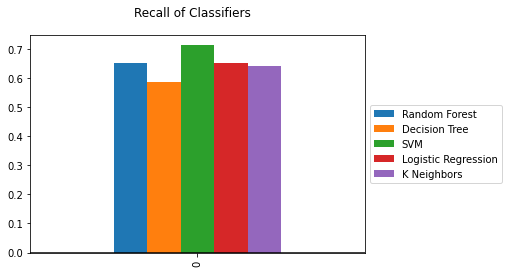

In [20]:
recallFrame = pd.DataFrame({
    'Random Forest': cvRandomForest_result["Recall"],
    'Decision Tree': cvDecisionTrees_result["Recall"],
    'SVM': cvSVM_result["Recall"],
    'Logistic Regression': cvLRC_result['Recall'],
    'K Neighbors': cvkN_result['Recall']
},index=[0])

recallFrame.plot(kind='bar')
plt.axhline(0, color='k')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.suptitle('Recall of Classifiers')

Curiously enough the recall is highest in SVM's.

Text(0.5, 0.98, 'F1 Scores of Classifiers')

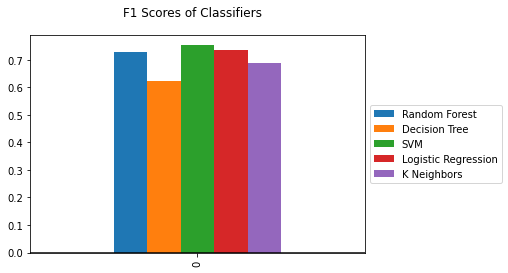

In [21]:
f1Frame = pd.DataFrame({
    'Random Forest': cvRandomForest_result["F1 Score"],
    'Decision Tree': cvDecisionTrees_result["F1 Score"],
    'SVM': cvSVM_result["F1 Score"],
    'Logistic Regression': cvLRC_result['F1 Score'],
    'K Neighbors': cvkN_result['F1 Score']
},index=[0])

f1Frame.plot(kind='bar')
plt.axhline(0, color='k')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.suptitle('F1 Scores of Classifiers')

Interestingly SVM's lead in the F1 Score(composition of precision and recall)

#### Remarks

Based on the results I decided to not evaulate decision trees on further experimentation as it seemed the weakest performer.

## Playing with different hyperparameters on the different classifiers

Below we use grid search to generate best values for parameters to create the best possible models.

In [22]:
parameters = {'min_samples_split': [2, 3, 4, 5, 6]}
randomForestClassifier = GridSearchCV(RandomForestClassifier(oob_score=True),parameters).fit(Xt, yt)
randomForestPredictions = randomForestClassifier.predict(Xv)
best_params = randomForestClassifier.best_params_

bestRandomForestClassifier = RandomForestClassifier(oob_score=True, min_samples_split=best_params['min_samples_split'])
bestRandomForestClassifier.fit(Xt, yt)

bestRandomForestClassifierPred = bestRandomForestClassifier.predict(Xv)
printScoresInSampleRun(yv, bestRandomForestClassifierPred, bestRandomForestClassifier, Xv)
print('OOB Error :', np.round(1 - bestRandomForestClassifier.oob_score_, 4))

cvRandomForestTuned = cross_validate(bestRandomForestClassifier, X, y, scoring=scoringRandomForest, cv=fold)

cvRandomForest_ResultTuned = pd.DataFrame({
    'Model': 'RandomForestClassifier',
    'Accuracy': np.round(cvRandomForestTuned['test_accuracy'].mean(), 4),
    'Precision': np.round(cvRandomForestTuned['test_precision'].mean(), 4),
    'Recall': np.round(cvRandomForestTuned['test_recall'].mean(), 4),
    'F1 Score': np.round(cvRandomForestTuned['test_f1 score'].mean(), 4),
    'ROC AUC': np.round(cvRandomForestTuned['test_roc auc'].mean(), 4),
    'OOB Error': np.round(cvRandomForestTuned['test_oob'].mean(), 4)
},index=[0])
cvRandomForest_ResultTuned

Accuracy Score : 0.8233
Precision Score : 0.7681
Recall Score : 0.5889
F1 Score : 0.6667
AUC Score : 0.9045
OOB Error : 0.1671


,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC,OOB Error
0,RandomForestClassifier,0.849,0.8394,0.6398,0.7223,0.7917,0.1695


In [23]:
supportVectorClassifier = svm.SVC(probability = True)
parameters = {'kernel':('linear', 'rbf'), 'C': [0.1, 1, 100, 1000], 'gamma': [0.0001, 0.001, 0.005, 0.1, 1, 3, 5]}
clf = GridSearchCV(supportVectorClassifier, parameters)
clf.fit(Xt, yt)
best_params = clf.best_params_

best_svm = svm.SVC(kernel=best_params['kernel'], C=best_params["C"],gamma=best_params["gamma"], probability = True)
best_svm.fit(Xt, yt)

cvTuning = cross_validate(best_svm, X, y, scoring=scoring2, cv=fold)
best_svmPred = best_svm.predict(Xv)

printScoresInSampleRun(yv, best_svmPred, best_svm, Xv)

cvSVM_resultTuned = pd.DataFrame({
    'Model': 'SVM',
    'Accuracy': np.round(cvTuning['test_accuracy'].mean(), 4),
    'Precision': np.round(cvTuning['test_precision'].mean(), 4),
    'Recall': np.round(cvTuning['test_recall'].mean(), 4),
    'F1 Score': np.round(cvTuning['test_f1 score'].mean(), 4),
    'ROC AUC': np.round(cvTuning['test_roc auc'].mean(), 4)
},index=[0])
cvSVM_resultTuned

Accuracy Score : 0.86
Precision Score : 0.8243
Recall Score : 0.6778
F1 Score : 0.7439
AUC Score : 0.9247


,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,SVM,0.851,0.8039,0.7002,0.7434,0.8103


In [24]:
parameters = {'C': [0.1, 1, 100, 1000], 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}
logisticRegressionClassifier = GridSearchCV(LogisticRegression(max_iter = 10000), parameters).fit(Xt,yt)
lrcPredictions = logisticRegressionClassifier.predict(Xv)
best_params = logisticRegressionClassifier.best_params_

best_lrc = LogisticRegression(C = best_params['C'], solver = best_params['solver'], max_iter = 10000)
best_lrc.fit(Xt, yt)

best_lrcPredictions = best_lrc.predict(Xv)
printScoresInSampleRun(yv, best_lrcPredictions, best_lrc, Xv)

cvLRC = cross_validate(best_lrc, X, y, scoring=scoring2, cv=fold)
cvLRC_resultTuned = pd.DataFrame({
    'Model': 'LogisticRegression',
    'Accuracy': np.round(cvLRC['test_accuracy'].mean(), 4),
    'Precision': np.round(cvLRC['test_precision'].mean(), 4),
    'Recall': np.round(cvLRC['test_recall'].mean(), 4),
    'F1 Score': np.round(cvLRC['test_f1 score'].mean(), 4),
    'ROC AUC': np.round(cvLRC['test_roc auc'].mean(), 4)
},index=[0])
cvLRC_resultTuned

Accuracy Score : 0.8733
Precision Score : 0.8095
Recall Score : 0.7556
F1 Score : 0.7816
AUC Score : 0.9284


,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,LogisticRegression,0.854,0.7817,0.7527,0.7619,0.8263


In [25]:
parameters = {'n_neighbors': [1, 2, 3, 4, 5, 10, 15], 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}
kNeighborsClassifier = GridSearchCV(KNeighborsClassifier(), parameters).fit(Xt,yt)
kNPredictions = kNeighborsClassifier.predict(Xv)
best_params = kNeighborsClassifier.best_params_

best_kNeighborsClassifier = KNeighborsClassifier(n_neighbors = best_params['n_neighbors'], algorithm = best_params['algorithm'])
best_kNeighborsClassifier.fit(Xt, yt)

best_kNeighborsClassifierPred = best_kNeighborsClassifier.predict(Xv)
printScoresInSampleRun(yv, best_kNeighborsClassifierPred, best_kNeighborsClassifier, Xv)

cvkNTuned = cross_validate(best_kNeighborsClassifier, X, y, scoring=scoring2, cv=fold)
cvkN_resultTuned = pd.DataFrame({
    'Model': 'k-Neighbors',
    'Accuracy': np.round(cvkNTuned['test_accuracy'].mean(), 4),
    'Precision': np.round(cvkNTuned['test_precision'].mean(), 4),
    'Recall': np.round(cvkNTuned['test_recall'].mean(), 4),
    'F1 Score': np.round(cvkNTuned['test_f1 score'].mean(), 4),
    'ROC AUC': np.round(cvkNTuned['test_roc auc'].mean(), 4)
},index=[0])
cvkN_resultTuned

Accuracy Score : 0.83
Precision Score : 0.7241
Recall Score : 0.7
F1 Score : 0.7119
AUC Score : 0.8743


,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,k-Neighbors,0.82,0.7481,0.6419,0.6887,0.7716


Text(0.5, 0.98, 'Accuracies of Classifiers')

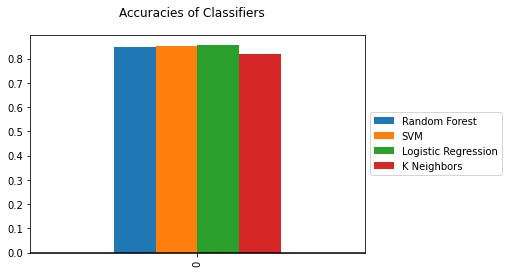

In [26]:
accuracyFrame = pd.DataFrame({
    'Random Forest': cvRandomForest_ResultTuned["Accuracy"],
    'SVM': cvSVM_resultTuned["Accuracy"],
    'Logistic Regression': cvLRC_resultTuned['Accuracy'],
    'K Neighbors': cvkN_resultTuned['Accuracy']
},index=[0])

accuracyFrame.plot(kind='bar')
plt.axhline(0, color='k')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.suptitle('Accuracies of Classifiers')

Text(0.5, 0.98, 'Precisions of Classifiers')

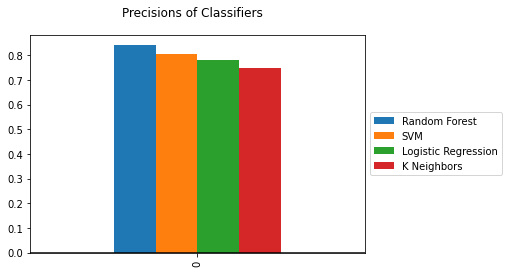

In [27]:
precisionFrame = pd.DataFrame({
    'Random Forest': cvRandomForest_ResultTuned["Precision"],
    'SVM': cvSVM_resultTuned["Precision"],
    'Logistic Regression': cvLRC_resultTuned['Precision'],
    'K Neighbors': cvkN_resultTuned['Precision']
},index=[0])

precisionFrame.plot(kind='bar')
plt.axhline(0, color='k')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.suptitle('Precisions of Classifiers')

Text(0.5, 0.98, 'Recalls of Classifiers')

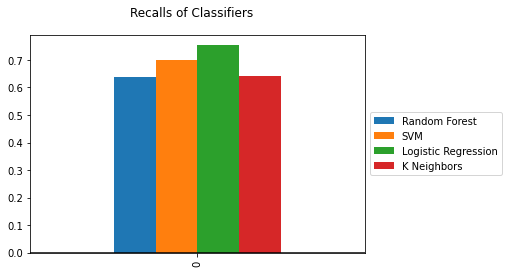

In [28]:
recallFrame = pd.DataFrame({
    'Random Forest': cvRandomForest_ResultTuned["Recall"],
    'SVM': cvSVM_resultTuned["Recall"],
    'Logistic Regression': cvLRC_resultTuned['Recall'],
    'K Neighbors': cvkN_resultTuned['Recall']
},index=[0])

recallFrame.plot(kind='bar')
plt.axhline(0, color='k')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.suptitle('Recalls of Classifiers')

Text(0.5, 0.98, 'F1 scores of Classifiers')

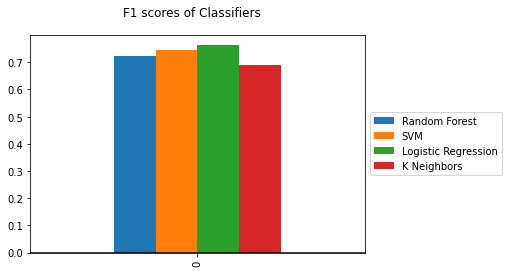

In [29]:
f1Frame = pd.DataFrame({
    'Random Forest': cvRandomForest_ResultTuned["F1 Score"],
    'SVM': cvSVM_resultTuned["F1 Score"],
    'Logistic Regression': cvLRC_resultTuned['F1 Score'],
    'K Neighbors': cvkN_resultTuned['F1 Score']
},index=[0])

f1Frame.plot(kind='bar')
plt.axhline(0, color='k')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.suptitle('F1 scores of Classifiers')

### Remarks

After tuning, we got SVM's leading in accuracy, random forests in precision and logistic regression in recall. So if you wanted to evaluate your data without adding features, you'd use SVM's if you want an accurate model, random forests if you wanted to prioritize that your "interesting" event is actually right, and logistic regression for when you wanted to prioritize the model not misidentifying an interesting event.

## Playing around with Stops and Turns
Here we added both stops and turns to see how that might affect results


In [30]:
XwithStopsandTurnst, XwithStopsandTurnsv, ywithStopsandTurnst, ywithStopsandTurnsv = train_test_split(XwithStopsandTurns, y, test_size=0.3)

In [31]:
randomForestClassifierSandT = RandomForestClassifier(oob_score=True)
randomForestClassifierSandT.fit(XwithStopsandTurnst, ywithStopsandTurnst)
randomForestClassifierSandTPred = randomForestClassifierSandT.predict(XwithStopsandTurnsv)

printScoresInSampleRun(ywithStopsandTurnsv, randomForestClassifierSandTPred, randomForestClassifierSandT, XwithStopsandTurnsv)

cvRandomForestST = cross_validate(RandomForestClassifier(oob_score=True), XwithStopsandTurns, y, scoring=scoringRandomForest, cv=fold)
cvRandomForestST_result = pd.DataFrame({
    'Model': 'RandomForestClassifierStopsTurns',
    'Accuracy': np.round(cvRandomForestST['test_accuracy'].mean(), 4),
    'Precision': np.round(cvRandomForestST['test_precision'].mean(), 4),
    'Recall': np.round(cvRandomForestST['test_recall'].mean(), 4),
    'F1 Score': np.round(cvRandomForestST['test_f1 score'].mean(), 4),
    'ROC AUC': np.round(cvRandomForestST['test_roc auc'].mean(), 4),
        'OOB Error': np.round(cvRandomForestST['test_oob'].mean(), 4)
},index=[0])
cvRandomForestST_result

Accuracy Score : 0.8267
Precision Score : 0.8082
Recall Score : 0.6082
F1 Score : 0.6941
AUC Score : 0.9037


,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC,OOB Error
0,RandomForestClassifierStopsTurns,0.85,0.8187,0.6672,0.7332,0.8002,0.1615


In [32]:
svmClassifierSandT = svm.SVC(probability=True)
svmClassifierSandT.fit(XwithStopsandTurnst, ywithStopsandTurnst)
svmClassifierSandTPred = svmClassifierSandT.predict(XwithStopsandTurnsv)

printScoresInSampleRun(ywithStopsandTurnsv, svmClassifierSandTPred, svmClassifierSandT, XwithStopsandTurnsv)

cvsvmST = cross_validate(svm.SVC(), XwithStopsandTurns, y, scoring=scoring2, cv=fold)
cvsvmST_result = pd.DataFrame({
    'Model': 'SVMStopsTurns',
    'Accuracy': np.round(cvsvmST['test_accuracy'].mean(), 4),
    'Precision': np.round(cvsvmST['test_precision'].mean(), 4),
    'Recall': np.round(cvsvmST['test_recall'].mean(), 4),
    'F1 Score': np.round(cvsvmST['test_f1 score'].mean(), 4),
    'ROC AUC': np.round(cvsvmST['test_roc auc'].mean(), 4)
},index=[0])
cvsvmST_result

Accuracy Score : 0.8433
Precision Score : 0.7778
Recall Score : 0.7216
F1 Score : 0.7487
AUC Score : 0.9174


,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,SVMStopsTurns,0.864,0.8187,0.7272,0.7669,0.8267


In [33]:
logisticRegressionClassifierST = LogisticRegression()
logisticRegressionClassifierST.fit(XwithStopsandTurnst, ywithStopsandTurnst)
logisticRegressionClassifierSTPred = logisticRegressionClassifierST.predict(XwithStopsandTurnsv)

printScoresInSampleRun(ywithStopsandTurnsv, logisticRegressionClassifierSTPred, logisticRegressionClassifierST, XwithStopsandTurnsv)

cvLRCST = cross_validate(LogisticRegression(), XwithStopsandTurns, y, scoring=scoring2, cv=fold)
cvLRCST_result = pd.DataFrame({
    'Model': 'LogisticRegressionStopsTurns',
    'Accuracy': np.round(cvLRCST['test_accuracy'].mean(), 4),
    'Precision': np.round(cvLRCST['test_precision'].mean(), 4),
    'Recall': np.round(cvLRCST['test_recall'].mean(), 4),
    'F1 Score': np.round(cvLRCST['test_f1 score'].mean(), 4),
    'ROC AUC': np.round(cvLRCST['test_roc auc'].mean(), 4)
},index=[0])
cvLRCST_result

Accuracy Score : 0.8433
Precision Score : 0.8472
Recall Score : 0.6289
F1 Score : 0.7219
AUC Score : 0.9147


,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,LogisticRegressionStopsTurns,0.86,0.8656,0.6626,0.7437,0.806


In [34]:
kNeighborsClassifierST = KNeighborsClassifier()
kNeighborsClassifierST.fit(XwithStopsandTurnst, ywithStopsandTurnst)
kNeighborsClassifierSTPred = kNeighborsClassifierST.predict(XwithStopsandTurnsv)

printScoresInSampleRun(ywithStopsandTurnsv, kNeighborsClassifierSTPred, kNeighborsClassifierST, XwithStopsandTurnsv)

cvKNST = cross_validate(KNeighborsClassifier(), XwithStopsandTurns, y, scoring=scoring2, cv=fold)
cvKNST_result = pd.DataFrame({
    'Model': 'KNeighborsStopsTurns',
    'Accuracy': np.round(cvKNST['test_accuracy'].mean(), 4),
    'Precision': np.round(cvKNST['test_precision'].mean(), 4),
    'Recall': np.round(cvKNST['test_recall'].mean(), 4),
    'F1 Score': np.round(cvKNST['test_f1 score'].mean(), 4),
    'ROC AUC': np.round(cvKNST['test_roc auc'].mean(), 4)
},index=[0])
cvKNST_result

Accuracy Score : 0.8033
Precision Score : 0.7639
Recall Score : 0.567
F1 Score : 0.6509
AUC Score : 0.8467


,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,KNeighborsStopsTurns,0.8,0.727,0.5753,0.6392,0.7391


Text(0.5, 0.98, 'Accuracy of Classifiers with Stops and Turns')

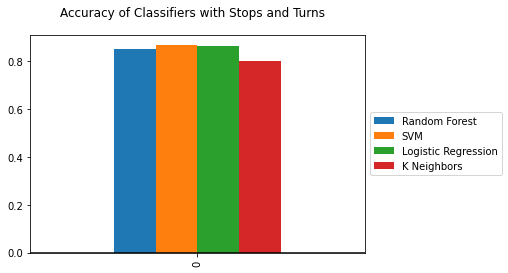

In [35]:
accuracySTFrame = pd.DataFrame({
    'Random Forest': cvRandomForestST_result["Accuracy"],
    'SVM': cvsvmST_result["Accuracy"],
    'Logistic Regression': cvLRCST_result['Accuracy'],
    'K Neighbors': cvKNST_result['Accuracy']
},index=[0])

accuracySTFrame.plot(kind='bar')
plt.axhline(0, color='k')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.suptitle('Accuracy of Classifiers with Stops and Turns')

Text(0.5, 0.98, 'Precision of Classifiers with Stops and Turns')

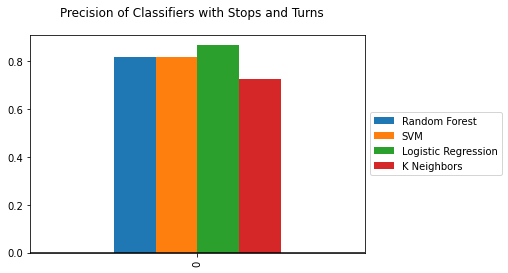

In [36]:
precisionSTFrame = pd.DataFrame({
    'Random Forest': cvRandomForestST_result["Precision"],
    'SVM': cvsvmST_result["Precision"],
    'Logistic Regression': cvLRCST_result['Precision'],
    'K Neighbors': cvKNST_result['Precision']
},index=[0])

precisionSTFrame.plot(kind='bar')
plt.axhline(0, color='k')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.suptitle('Precision of Classifiers with Stops and Turns')

Text(0.5, 0.98, 'Recall of Classifiers with Stops and Turns')

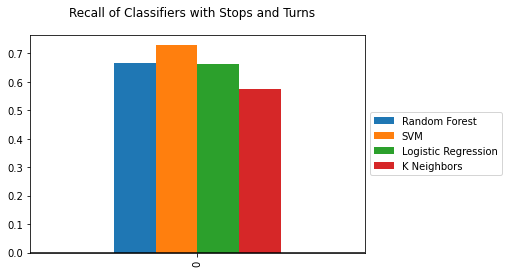

In [37]:
recallSTFrame = pd.DataFrame({
    'Random Forest': cvRandomForestST_result["Recall"],
    'SVM': cvsvmST_result["Recall"],
    'Logistic Regression': cvLRCST_result['Recall'],
    'K Neighbors': cvKNST_result['Recall']
},index=[0])

recallSTFrame.plot(kind='bar')
plt.axhline(0, color='k')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.suptitle('Recall of Classifiers with Stops and Turns')

Text(0.5, 0.98, 'F1 of Classifiers with Stops and Turns')

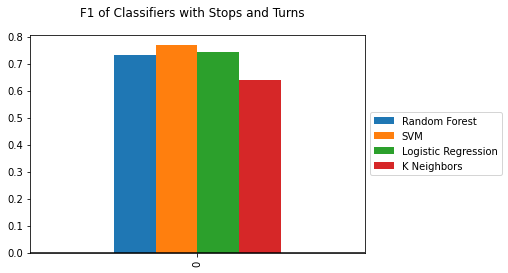

In [38]:
f1STFrame = pd.DataFrame({
    'Random Forest': cvRandomForestST_result["F1 Score"],
    'SVM': cvsvmST_result["F1 Score"],
    'Logistic Regression': cvLRCST_result['F1 Score'],
    'K Neighbors': cvKNST_result['F1 Score']
},index=[0])

f1STFrame.plot(kind='bar')
plt.axhline(0, color='k')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.suptitle('F1 of Classifiers with Stops and Turns')

## Playing With Hyperparameters and Stops and Turns

In [39]:
parameters = {'min_samples_split': [2, 3, 4, 5, 6]}
clf = GridSearchCV(RandomForestClassifier(oob_score=True),parameters)
clf.fit(XwithStopsandTurnst, ywithStopsandTurnst)
best_params = clf.best_params_

best_RandomForestST_Tuned = RandomForestClassifier(min_samples_split=best_params['min_samples_split'], oob_score=True)
best_RandomForestST_Tuned.fit(XwithStopsandTurnst, ywithStopsandTurnst)

best_RandomForestST_TunedPred = best_RandomForestST_Tuned.predict(XwithStopsandTurnsv)
printScoresInSampleRun(ywithStopsandTurnsv, best_RandomForestST_TunedPred, best_RandomForestST_Tuned, XwithStopsandTurnsv)
print('OOB Error :', np.round(1 - best_RandomForestST_Tuned.oob_score_, 4))

cvRandomForestST_Tuned = cross_validate(best_RandomForestST_Tuned, XwithStopsandTurns, y, scoring=scoringRandomForest, cv=fold)
cvRandomForestST_Tuned_result = pd.DataFrame({
    'Model': 'RandomForestClassifierStopsTurnsTuned',
    'Accuracy': np.round(cvRandomForestST_Tuned['test_accuracy'].mean(), 4),
    'Precision': np.round(cvRandomForestST_Tuned['test_precision'].mean(), 4),
    'Recall': np.round(cvRandomForestST_Tuned['test_recall'].mean(), 4),
    'F1 Score': np.round(cvRandomForestST_Tuned['test_f1 score'].mean(), 4),
    'ROC AUC': np.round(cvRandomForestST_Tuned['test_roc auc'].mean(), 4),
        'OOB Error': np.round(cvRandomForestST_Tuned['test_oob'].mean(), 4)
},index=[0])
cvRandomForestST_Tuned_result

Accuracy Score : 0.84
Precision Score : 0.8657
Recall Score : 0.5979
F1 Score : 0.7073
AUC Score : 0.9007
OOB Error : 0.15


,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC,OOB Error
0,RandomForestClassifierStopsTurnsTuned,0.845,0.8227,0.6439,0.7195,0.79,0.158


In [40]:
parameters = {'kernel':('linear', 'rbf'), 'C': [0.1, 1, 100, 1000], 'gamma': [0.0001, 0.001, 0.005, 0.1, 1, 3, 5]}
clf = GridSearchCV(svm.SVC(probability = True), parameters)
clf.fit(XwithStopsandTurnst, ywithStopsandTurnst)
best_params = clf.best_params_

best_svmST_Tuned = svm.SVC(kernel=best_params['kernel'], C=best_params["C"],gamma=best_params["gamma"], probability = True)
best_svmST_Tuned.fit(XwithStopsandTurnst, ywithStopsandTurnst)

best_svmSTPred_Tuned = best_svmST_Tuned.predict(XwithStopsandTurnsv)

printScoresInSampleRun(ywithStopsandTurnsv, best_svmSTPred_Tuned, best_svmST_Tuned, XwithStopsandTurnsv)

cvSVMSTTuning = cross_validate(best_svmST_Tuned, XwithStopsandTurns, y, scoring=scoring2, cv=fold)
cvSVMST_resultTuned = pd.DataFrame({
    'Model': 'SVMStopsTurnsTuned',
    'Accuracy': np.round(cvSVMSTTuning['test_accuracy'].mean(), 4),
    'Precision': np.round(cvSVMSTTuning['test_precision'].mean(), 4),
    'Recall': np.round(cvSVMSTTuning['test_recall'].mean(), 4),
    'F1 Score': np.round(cvSVMSTTuning['test_f1 score'].mean(), 4),
    'ROC AUC': np.round(cvSVMSTTuning['test_roc auc'].mean(), 4)
},index=[0])
cvSVMST_resultTuned

Accuracy Score : 0.86
Precision Score : 0.7957
Recall Score : 0.7629
F1 Score : 0.7789
AUC Score : 0.9298


,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,SVMStopsTurnsTuned,0.865,0.7931,0.769,0.7789,0.8389


In [41]:
parameters = {'C': [0.1, 1, 100, 1000], 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}
logisticRegressionClassifierST = GridSearchCV(LogisticRegression(max_iter = 10000), parameters)
logisticRegressionClassifierST.fit(XwithStopsandTurnst,ywithStopsandTurnst)
best_params = logisticRegressionClassifierST.best_params_

best_lrcST_Tuned = LogisticRegression(C = best_params['C'], solver = best_params['solver'], max_iter = 10000)
best_lrcST_Tuned.fit(XwithStopsandTurnst, ywithStopsandTurnst)

best_lrcST_TunedPred = best_lrcST_Tuned.predict(XwithStopsandTurnsv)
printScoresInSampleRun(ywithStopsandTurnsv, best_lrcST_TunedPred, best_lrcST_Tuned, XwithStopsandTurnsv)

cvLRCST = cross_validate(best_lrcST_Tuned, XwithStopsandTurns, y, scoring=scoring2, cv=fold)
cvLRCST_resultTuned = pd.DataFrame({
    'Model': 'LogisticRegressionStopsTurnsTuned',
    'Accuracy': np.round(cvLRCST['test_accuracy'].mean(), 4),
    'Precision': np.round(cvLRCST['test_precision'].mean(), 4),
    'Recall': np.round(cvLRCST['test_recall'].mean(), 4),
    'F1 Score': np.round(cvLRCST['test_f1 score'].mean(), 4),
    'ROC AUC': np.round(cvLRCST['test_roc auc'].mean(), 4)
},index=[0])
cvLRCST_resultTuned

Accuracy Score : 0.85
Precision Score : 0.7708
Recall Score : 0.7629
F1 Score : 0.7668
AUC Score : 0.9164


,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,LogisticRegressionStopsTurnsTuned,0.853,0.7752,0.7559,0.7608,0.8265


It sacrificed a little accuracy to boost the recall, F1 Score and AUC

In [42]:
parameters = {'n_neighbors': [1, 2, 3, 4, 5, 10, 15], 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}
kNeighborsClassifierClassifierST = GridSearchCV(KNeighborsClassifier(), parameters)
kNeighborsClassifierClassifierST.fit(XwithStopsandTurnst, ywithStopsandTurnst)
KNeighborsClassifierSTPredictions = kNeighborsClassifierClassifierST.predict(XwithStopsandTurnsv)
best_params = kNeighborsClassifierClassifierST.best_params_

best_kNST_Tuned = KNeighborsClassifier(n_neighbors = best_params['n_neighbors'], algorithm = best_params['algorithm'])
best_kNST_Tuned.fit(XwithStopsandTurnst, ywithStopsandTurnst)

best_kNST_TunedPred = best_kNST_Tuned.predict(XwithStopsandTurnsv)
printScoresInSampleRun(ywithStopsandTurnsv, best_kNST_TunedPred, best_kNST_Tuned, XwithStopsandTurnsv)

cvkNST = cross_validate(best_kNST_Tuned, XwithStopsandTurns, y, scoring=scoring2, cv=fold)
cvkNST_resultTuned = pd.DataFrame({
    'Model': 'K-NeighborsStopsTurnsTuned',
    'Accuracy': np.round(cvkNST['test_accuracy'].mean(), 4),
    'Precision': np.round(cvkNST['test_precision'].mean(), 4),
    'Recall': np.round(cvkNST['test_recall'].mean(), 4),
    'F1 Score': np.round(cvkNST['test_f1 score'].mean(), 4),
    'ROC AUC': np.round(cvkNST['test_roc auc'].mean(), 4)
},index=[0])
cvkNST_resultTuned

Accuracy Score : 0.8067
Precision Score : 0.8421
Recall Score : 0.4948
F1 Score : 0.6234
AUC Score : 0.8669


,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,K-NeighborsStopsTurnsTuned,0.798,0.7889,0.4911,0.6012,0.7144


Text(0.5, 0.98, 'Accuracies of Classifiers Tuned with Stops and Turns')

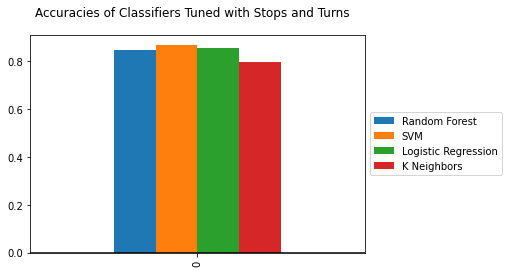

In [43]:
accuracyStopsTurnsTunedFrame = pd.DataFrame({
    'Random Forest': cvRandomForestST_Tuned_result["Accuracy"],
    'SVM': cvSVMST_resultTuned["Accuracy"],
    'Logistic Regression': cvLRCST_resultTuned['Accuracy'],
    'K Neighbors': cvkNST_resultTuned['Accuracy']
},index=[0])

accuracyStopsTurnsTunedFrame.plot(kind='bar')
plt.axhline(0, color='k')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.suptitle('Accuracies of Classifiers Tuned with Stops and Turns')

Text(0.5, 0.98, 'Precision of Classifiers Tuned with Stops and Turns')

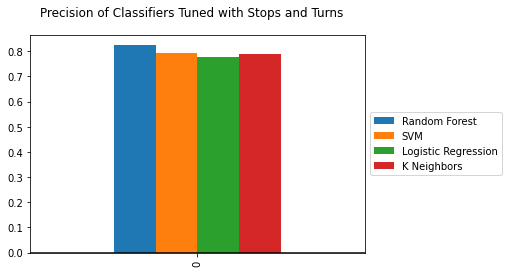

In [44]:
precisionStopsTurnsTunedFrame = pd.DataFrame({
    'Random Forest': cvRandomForestST_Tuned_result["Precision"],
    'SVM': cvSVMST_resultTuned["Precision"],
    'Logistic Regression': cvLRCST_resultTuned['Precision'],
    'K Neighbors': cvkNST_resultTuned['Precision']
},index=[0])

precisionStopsTurnsTunedFrame.plot(kind='bar')
plt.axhline(0, color='k')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.suptitle('Precision of Classifiers Tuned with Stops and Turns')

Text(0.5, 0.98, 'Recall of Classifiers Tuned with Stops and Turns')

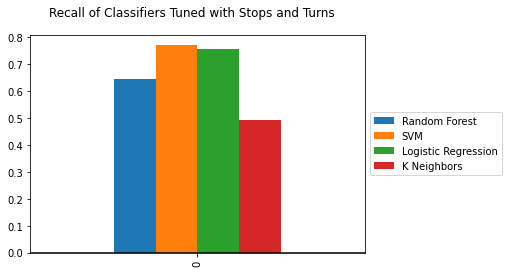

In [45]:
recallStopsTurnsTunedFrame = pd.DataFrame({
    'Random Forest': cvRandomForestST_Tuned_result["Recall"],
    'SVM': cvSVMST_resultTuned["Recall"],
    'Logistic Regression': cvLRCST_resultTuned['Recall'],
    'K Neighbors': cvkNST_resultTuned['Recall']
},index=[0])

recallStopsTurnsTunedFrame.plot(kind='bar')
plt.axhline(0, color='k')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.suptitle('Recall of Classifiers Tuned with Stops and Turns')

Text(0.5, 0.98, 'F1 Score of Classifiers Tuned with Stops and Turns')

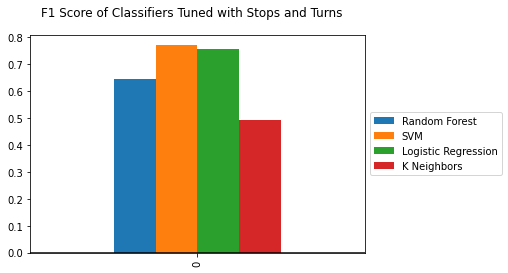

In [46]:
f1StopsTurnsTunedFrame = pd.DataFrame({
    'Random Forest': cvRandomForestST_Tuned_result["F1 Score"],
    'SVM': cvSVMST_resultTuned["F1 Score"],
    'Logistic Regression': cvLRCST_resultTuned['F1 Score'],
    'K Neighbors': cvkNST_resultTuned['F1 Score']
},index=[0])

recallStopsTurnsTunedFrame.plot(kind='bar')
plt.axhline(0, color='k')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.suptitle('F1 Score of Classifiers Tuned with Stops and Turns')

## Playing around with Stops

In [47]:
XwithStopst, XwithStopsv, ywithStopst, ywithStopsv = train_test_split(XwithStops, y, test_size=0.3)

In [48]:
randomForestClassifierS = RandomForestClassifier(oob_score=True)
randomForestClassifierS.fit(XwithStopst, ywithStopst)
randomForestClassifierSPred = randomForestClassifierS.predict(XwithStopsv)

printScoresInSampleRun(ywithStopsv, randomForestClassifierSPred, randomForestClassifierS, XwithStopsv)
print('OOB Error :', np.round(1 - randomForestClassifierS.oob_score_, 4))

cvRandomForestS = cross_validate(RandomForestClassifier(oob_score=True), XwithStops, y, scoring=scoringRandomForest, cv=fold)
cvRandomForestS_result = pd.DataFrame({
    'Model': 'RandomForestClassifierStops',
    'Accuracy': np.round(cvRandomForestS['test_accuracy'].mean(), 4),
    'Precision': np.round(cvRandomForestS['test_precision'].mean(), 4),
    'Recall': np.round(cvRandomForestS['test_recall'].mean(), 4),
    'F1 Score': np.round(cvRandomForestS['test_f1 score'].mean(), 4),
    'ROC AUC': np.round(cvRandomForestS['test_roc auc'].mean(), 4),
    'OOB Error': np.round(cvRandomForestS['test_oob'].mean(), 4)
},index=[0])
cvRandomForestS_result

Accuracy Score : 0.8267
Precision Score : 0.8209
Recall Score : 0.5789
F1 Score : 0.679
AUC Score : 0.8959
OOB Error : 0.16


,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC,OOB Error
0,RandomForestClassifierStops,0.85,0.8438,0.6378,0.7228,0.7921,0.1695


In [49]:
svmClassifierS = svm.SVC(probability=True)
svmClassifierS.fit(XwithStopst, ywithStopst)
svmClassifierSPred = svmClassifierS.predict(XwithStopsv)

printScoresInSampleRun(ywithStopsv, svmClassifierSPred, svmClassifierS, XwithStopsv)

cvsvmS = cross_validate(svm.SVC(), XwithStops, y, scoring=scoring2, cv=fold)
cvsvmS_results = pd.DataFrame({
    'Model': 'SVCStops',
    'Accuracy': np.round(cvsvmS['test_accuracy'].mean(), 4),
    'Precision': np.round(cvsvmS['test_precision'].mean(), 4),
    'Recall': np.round(cvsvmS['test_recall'].mean(), 4),
    'F1 Score': np.round(cvsvmS['test_f1 score'].mean(), 4),
    'ROC AUC': np.round(cvsvmS['test_roc auc'].mean(), 4)
},index=[0])
cvsvmS_results

Accuracy Score : 0.85
Precision Score : 0.8125
Recall Score : 0.6842
F1 Score : 0.7429
AUC Score : 0.9255


,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,SVCStops,0.851,0.7978,0.7083,0.7461,0.812


In [50]:
logisticRegressionClassifierS = LogisticRegression()
logisticRegressionClassifierS.fit(XwithStopst, ywithStopst)
logisticRegressionClassifierSPred = logisticRegressionClassifierS.predict(XwithStopsv)

printScoresInSampleRun(ywithStopsv, logisticRegressionClassifierSPred, logisticRegressionClassifierS, XwithStopsv)

cvLRCS = cross_validate(LogisticRegression(), XwithStops, y, scoring=scoring2, cv=fold)
cvLRCS_result = pd.DataFrame({
    'Model': 'LogisticRegressionStopsTurns',
    'Accuracy': np.round(cvLRCS['test_accuracy'].mean(), 4),
    'Precision': np.round(cvLRCS['test_precision'].mean(), 4),
    'Recall': np.round(cvLRCS['test_recall'].mean(), 4),
    'F1 Score': np.round(cvLRCS['test_f1 score'].mean(), 4),
    'ROC AUC': np.round(cvLRCS['test_roc auc'].mean(), 4)
},index=[0])
cvLRCS_result

Accuracy Score : 0.8533
Precision Score : 0.8806
Recall Score : 0.6211
F1 Score : 0.7284
AUC Score : 0.9288


,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,LogisticRegressionStopsTurns,0.857,0.8619,0.6532,0.7373,0.8013


In [51]:
kNeighborsClassifierS = KNeighborsClassifier()
kNeighborsClassifierS.fit(XwithStopst, ywithStopst)
kNeighborsClassifierSPred = kNeighborsClassifierS.predict(XwithStopsv)

printScoresInSampleRun(ywithStopsv, kNeighborsClassifierSPred, kNeighborsClassifierS, XwithStopsv)

cvKNS = cross_validate(KNeighborsClassifier(), XwithStops, y, scoring=scoring2, cv=fold)
cvKNS_result = pd.DataFrame({
    'Model': 'KNeighborsStops',
    'Accuracy': np.round(cvKNS['test_accuracy'].mean(), 4),
    'Precision': np.round(cvKNS['test_precision'].mean(), 4),
    'Recall': np.round(cvKNS['test_recall'].mean(), 4),
    'F1 Score': np.round(cvKNS['test_f1 score'].mean(), 4),
    'ROC AUC': np.round(cvKNS['test_roc auc'].mean(), 4)
},index=[0])
cvKNS_result

Accuracy Score : 0.7833
Precision Score : 0.6923
Recall Score : 0.5684
F1 Score : 0.6243
AUC Score : 0.8447


,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,KNeighborsStops,0.798,0.7128,0.5899,0.6428,0.7414


Text(0.5, 0.98, 'Accuracy of Classifiers with Stops')

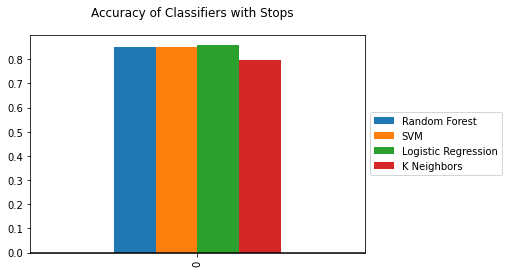

In [52]:
accuracyStopsFrame = pd.DataFrame({
    'Random Forest': cvRandomForestS_result["Accuracy"],
    'SVM': cvsvmS_results["Accuracy"],
    'Logistic Regression': cvLRCS_result['Accuracy'],
    'K Neighbors': cvKNS_result['Accuracy']
},index=[0])

accuracyStopsFrame.plot(kind='bar')
plt.axhline(0, color='k')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.suptitle('Accuracy of Classifiers with Stops')

Text(0.5, 0.98, 'Precision of Classifiers with Stops')

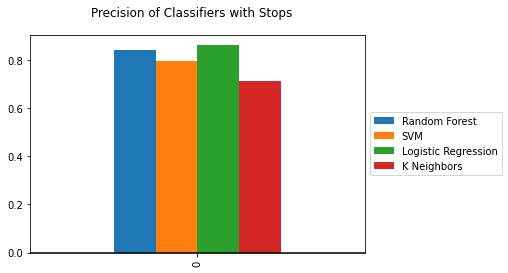

In [53]:
precisionStopsFrame = pd.DataFrame({
    'Random Forest': cvRandomForestS_result["Precision"],
    'SVM': cvsvmS_results["Precision"],
    'Logistic Regression': cvLRCS_result['Precision'],
    'K Neighbors': cvKNS_result['Precision']
},index=[0])

precisionStopsFrame.plot(kind='bar')
plt.axhline(0, color='k')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.suptitle('Precision of Classifiers with Stops')

Text(0.5, 0.98, 'Recall of Classifiers with Stops')

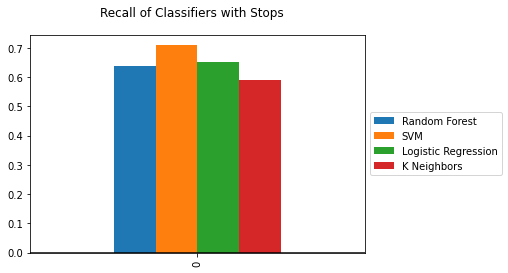

In [54]:
recallStopsFrame = pd.DataFrame({
    'Random Forest': cvRandomForestS_result["Recall"],
    'SVM': cvsvmS_results["Recall"],
    'Logistic Regression': cvLRCS_result['Recall'],
    'K Neighbors': cvKNS_result['Recall']
},index=[0])

recallStopsFrame.plot(kind='bar')
plt.axhline(0, color='k')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.suptitle('Recall of Classifiers with Stops')

Text(0.5, 0.98, 'F1 of Classifiers with Stops')

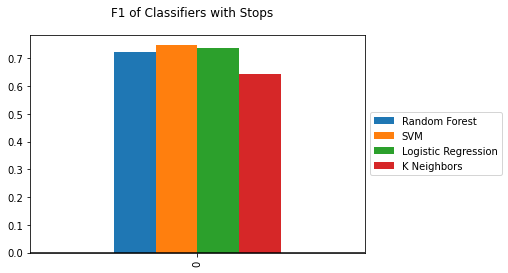

In [55]:
f1StopsFrame = pd.DataFrame({
    'Random Forest': cvRandomForestS_result["F1 Score"],
    'SVM': cvsvmS_results["F1 Score"],
    'Logistic Regression': cvLRCS_result['F1 Score'],
    'K Neighbors': cvKNS_result['F1 Score']
},index=[0])

f1StopsFrame.plot(kind='bar')
plt.axhline(0, color='k')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.suptitle('F1 of Classifiers with Stops')

## Playing Around with HyperParameters and Stops

In [56]:
parameters = {'min_samples_split': [2, 3, 4, 5, 6]}
clf = GridSearchCV(RandomForestClassifier(oob_score=True),parameters)
clf.fit(XwithStopst, ywithStopst)
best_params = clf.best_params_

best_RandomForestS_Tuned = RandomForestClassifier(min_samples_split=best_params['min_samples_split'], oob_score=True)
best_RandomForestS_Tuned.fit(XwithStopst, ywithStopst)

best_RandomForestS_TunedPred = best_RandomForestS_Tuned.predict(XwithStopsv)

printScoresInSampleRun(ywithStopsv, best_RandomForestS_TunedPred, best_RandomForestS_Tuned, XwithStopsv)
print('OOB Error :', np.round(1 - best_RandomForestS_Tuned.oob_score_, 4))

cvRandomForestS_Tuned = cross_validate(best_RandomForestST_Tuned, XwithStops, y, scoring=scoringRandomForest, cv=fold)
cvRandomForestS_Tuned_result = pd.DataFrame({
    'Model': 'RandomForestClassifierStopsTuned',
    'Accuracy': np.round(cvRandomForestS_Tuned['test_accuracy'].mean(), 4),
    'Precision': np.round(cvRandomForestS_Tuned['test_precision'].mean(), 4),
    'Recall': np.round(cvRandomForestS_Tuned['test_recall'].mean(), 4),
    'F1 Score': np.round(cvRandomForestS_Tuned['test_f1 score'].mean(), 4),
    'ROC AUC': np.round(cvRandomForestS_Tuned['test_roc auc'].mean(), 4),
        'OOB Error': np.round(cvRandomForestS_Tuned['test_oob'].mean(), 4)
},index=[0])
cvRandomForestS_Tuned_result

Accuracy Score : 0.82
Precision Score : 0.8154
Recall Score : 0.5579
F1 Score : 0.6625
AUC Score : 0.9039
OOB Error : 0.1614


,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC,OOB Error
0,RandomForestClassifierStopsTuned,0.844,0.8288,0.6291,0.7122,0.7848,0.174


In [57]:
parameters = {'kernel':('linear', 'rbf'), 'C': [0.1, 1, 100, 1000], 'gamma': [0.0001, 0.001, 0.005, 0.1, 1, 3, 5]}
clf = GridSearchCV(svm.SVC(probability = True), parameters)
clf.fit(XwithStopst, ywithStopst)
best_params = clf.best_params_

best_svmS_Tuned = svm.SVC(kernel=best_params['kernel'], C=best_params["C"],gamma=best_params["gamma"], probability = True)
best_svmS_Tuned.fit(XwithStopst, ywithStopst)

best_svmSPred_Tuned = best_svmS_Tuned.predict(XwithStopsv)

printScoresInSampleRun(ywithStopsv, best_svmSPred_Tuned, best_svmS_Tuned, XwithStopsv)
cvSVMSTuning = cross_validate(best_svmS_Tuned, XwithStops, y, scoring=scoring2, cv=fold)
cvSVMS_result_Tuned = pd.DataFrame({
    'Model': 'SVMStopsTuned',
    'Accuracy': np.round(cvSVMSTuning['test_accuracy'].mean(), 4),
    'Precision': np.round(cvSVMSTuning['test_precision'].mean(), 4),
    'Recall': np.round(cvSVMSTuning['test_recall'].mean(), 4),
    'F1 Score': np.round(cvSVMSTuning['test_f1 score'].mean(), 4),
    'ROC AUC': np.round(cvSVMSTuning['test_roc auc'].mean(), 4)
},index=[0])
cvSVMS_result_Tuned

Accuracy Score : 0.8567
Precision Score : 0.8095
Recall Score : 0.7158
F1 Score : 0.7598
AUC Score : 0.9054


,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,SVMStopsTuned,0.866,0.7889,0.7877,0.7837,0.8446


In [58]:
parameters = {'C': [0.1, 1, 100, 1000], 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}
clf = GridSearchCV(LogisticRegression(max_iter = 10000), parameters)
clf.fit(XwithStopst,ywithStopst)
best_params = clf.best_params_

best_lrcS_Tuned = LogisticRegression(C = best_params['C'], solver = best_params['solver'], max_iter = 10000)
best_lrcS_Tuned.fit(XwithStopst, ywithStopst)

best_lrcS_TunedPred = best_lrcS_Tuned.predict(XwithStopsv)
printScoresInSampleRun(ywithStopsv, best_lrcS_TunedPred, best_lrcS_Tuned, XwithStopsv)

cvLRCS = cross_validate(best_lrcS_Tuned, XwithStops, y, scoring=scoring2, cv=fold)
cvLRCS_resultTuned = pd.DataFrame({
    'Model': 'LogisticRegressionStopsTurnsTuned',
    'Accuracy': np.round(cvLRCS['test_accuracy'].mean(), 4),
    'Precision': np.round(cvLRCS['test_precision'].mean(), 4),
    'Recall': np.round(cvLRCS['test_recall'].mean(), 4),
    'F1 Score': np.round(cvLRCS['test_f1 score'].mean(), 4),
    'ROC AUC': np.round(cvLRCS['test_roc auc'].mean(), 4)
},index=[0])
cvLRCS_resultTuned

Accuracy Score : 0.8567
Precision Score : 0.825
Recall Score : 0.6947
F1 Score : 0.7543
AUC Score : 0.9085


,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,LogisticRegressionStopsTurnsTuned,0.857,0.7793,0.7653,0.7677,0.8318


In [59]:
parameters = {'n_neighbors': [1, 2, 3, 4, 5, 10, 15], 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}
clf = GridSearchCV(KNeighborsClassifier(), parameters)
clf.fit(XwithStopst, ywithStopst)
best_params = clf.best_params_

best_kNS_Tuned = KNeighborsClassifier(n_neighbors = best_params['n_neighbors'], algorithm = best_params['algorithm'])
best_kNS_Tuned.fit(XwithStopst, ywithStopst)

best_kNS_TunedPred = best_kNS_Tuned.predict(XwithStopsv)
printScoresInSampleRun(ywithStopsv, best_kNS_TunedPred, best_kNS_Tuned, XwithStopsv)

cvkNS = cross_validate(best_kNS_Tuned, XwithStops, y, scoring=scoring2, cv=fold)
cvkNS_resultTuned = pd.DataFrame({
    'Model': 'K-NeighborsStopsTuned',
    'Accuracy': np.round(cvkNS['test_accuracy'].mean(), 4),
    'Precision': np.round(cvkNS['test_precision'].mean(), 4),
    'Recall': np.round(cvkNS['test_recall'].mean(), 4),
    'F1 Score': np.round(cvkNS['test_f1 score'].mean(), 4),
    'ROC AUC': np.round(cvkNS['test_roc auc'].mean(), 4)
},index=[0])
cvkNS_resultTuned

Accuracy Score : 0.8067
Precision Score : 0.7284
Recall Score : 0.6211
F1 Score : 0.6705
AUC Score : 0.834


,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,K-NeighborsStopsTuned,0.781,0.6738,0.5832,0.6211,0.7274


Text(0.5, 0.98, 'Accuracy of Classifiers with Stops Tuned')

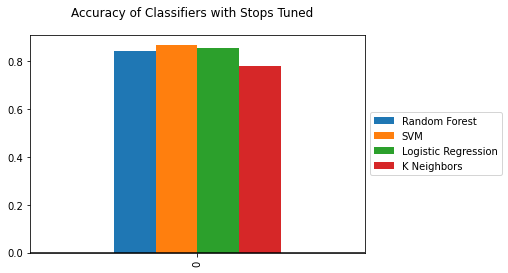

In [60]:
accuracyStopsFrame = pd.DataFrame({
    'Random Forest': cvRandomForestS_Tuned_result["Accuracy"],
    'SVM': cvSVMS_result_Tuned["Accuracy"],
    'Logistic Regression': cvLRCS_resultTuned['Accuracy'],
    'K Neighbors': cvkNS_resultTuned['Accuracy']
},index=[0])

accuracyStopsFrame.plot(kind='bar')
plt.axhline(0, color='k')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.suptitle('Accuracy of Classifiers with Stops Tuned')

Text(0.5, 0.98, 'Precision of Classifiers with Stops Tuned')

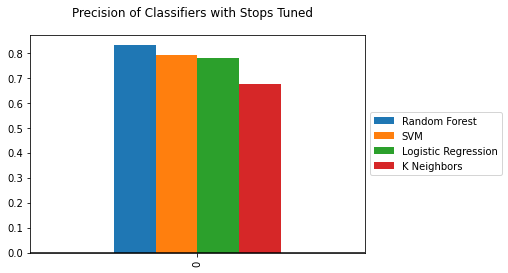

In [61]:
precisionStopsFrame = pd.DataFrame({
    'Random Forest': cvRandomForestS_Tuned_result["Precision"],
    'SVM': cvSVMS_result_Tuned["Precision"],
    'Logistic Regression': cvLRCS_resultTuned['Precision'],
    'K Neighbors': cvkNS_resultTuned['Precision']
},index=[0])

precisionStopsFrame.plot(kind='bar')
plt.axhline(0, color='k')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.suptitle('Precision of Classifiers with Stops Tuned')

Text(0.5, 0.98, 'Recall of Classifiers with Stops Tuned')

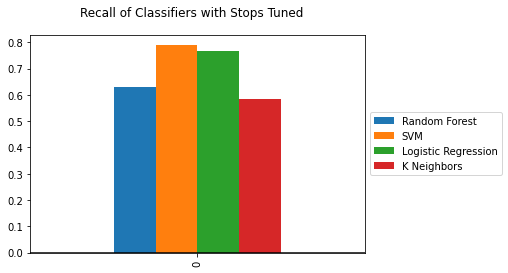

In [62]:
recallStopsFrame = pd.DataFrame({
    'Random Forest': cvRandomForestS_Tuned_result["Recall"],
    'SVM': cvSVMS_result_Tuned["Recall"],
    'Logistic Regression': cvLRCS_resultTuned['Recall'],
    'K Neighbors': cvkNS_resultTuned['Recall']
},index=[0])

recallStopsFrame.plot(kind='bar')
plt.axhline(0, color='k')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.suptitle('Recall of Classifiers with Stops Tuned')

Text(0.5, 0.98, 'f1 of Classifiers with Stops Tuned')

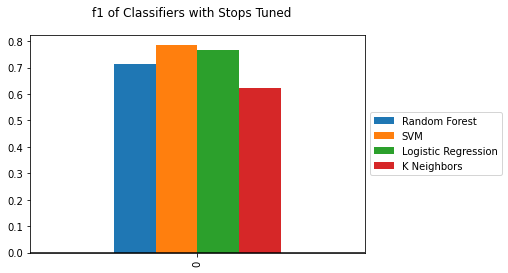

In [63]:
f1StopsFrame = pd.DataFrame({
    'Random Forest': cvRandomForestS_Tuned_result["F1 Score"],
    'SVM': cvSVMS_result_Tuned["F1 Score"],
    'Logistic Regression': cvLRCS_resultTuned['F1 Score'],
    'K Neighbors': cvkNS_resultTuned['F1 Score']
},index=[0])

f1StopsFrame.plot(kind='bar')
plt.axhline(0, color='k')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.suptitle('f1 of Classifiers with Stops Tuned')

## Playing Around With Turns

In [64]:
XwithTurnst, XwithTurnsv, ywithTurnst, ywithTurnsv = train_test_split(XwithTurns, y, test_size=0.3)

In [65]:
randomForestClassifierT = RandomForestClassifier(oob_score=True)
randomForestClassifierT.fit(XwithTurnst, ywithTurnst)
randomForestClassifierTPred = randomForestClassifierT.predict(XwithTurnsv)

printScoresInSampleRun(ywithTurnsv, randomForestClassifierTPred, randomForestClassifierT, XwithTurnsv)
print('OOB Error :', np.round(1 - randomForestClassifierT.oob_score_, 4))

cvRandomForestT = cross_validate(RandomForestClassifier(oob_score=True), XwithTurns, y, scoring=scoringRandomForest, cv=fold)
cvRandomForestT_result = pd.DataFrame({
    'Model': 'RandomForestClassifierStopsTurns',
    'Accuracy': np.round(cvRandomForestT['test_accuracy'].mean(), 4),
    'Precision': np.round(cvRandomForestT['test_precision'].mean(), 4),
    'Recall': np.round(cvRandomForestT['test_recall'].mean(), 4),
    'F1 Score': np.round(cvRandomForestT['test_f1 score'].mean(), 4),
    'ROC AUC': np.round(cvRandomForestT['test_roc auc'].mean(), 4),
        'OOB Error': np.round(cvRandomForestT['test_oob'].mean(), 4)
},index=[0])
cvRandomForestT_result

Accuracy Score : 0.8467
Precision Score : 0.8333
Recall Score : 0.6111
F1 Score : 0.7051
AUC Score : 0.8945
OOB Error : 0.1657


,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC,OOB Error
0,RandomForestClassifierStopsTurns,0.852,0.8414,0.6471,0.729,0.7961,0.166


In [66]:
svmClassifierT = svm.SVC(probability=True)
svmClassifierT.fit(XwithTurnst, ywithTurnst)
svmClassifierPredT = svmClassifierT.predict(XwithTurnsv)

printScoresInSampleRun(ywithTurnsv, svmClassifierPredT, svmClassifierT, XwithTurnsv)

cvsvmt = cross_validate(svm.SVC(), XwithTurns, y, scoring=scoring2, cv=fold)
cvsvm_resultT = pd.DataFrame({
    'Model': 'SVCTurns',
    'Accuracy': np.round(cvsvmt['test_accuracy'].mean(), 4),
    'Precision': np.round(cvsvmt['test_precision'].mean(), 4),
    'Recall': np.round(cvsvmt['test_recall'].mean(), 4),
    'F1 Score': np.round(cvsvmt['test_f1 score'].mean(), 4),
    'ROC AUC': np.round(cvsvmt['test_roc auc'].mean(), 4)
},index=[0])
cvsvm_resultT

Accuracy Score : 0.8767
Precision Score : 0.863
Recall Score : 0.7
F1 Score : 0.773
AUC Score : 0.9316


,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,SVCTurns,0.869,0.8378,0.7257,0.7735,0.8304


In [67]:
logisticRegressionClassifierT = LogisticRegression()
logisticRegressionClassifierT.fit(XwithTurnst, ywithTurnst)
logisticRegressionClassifierTPred = logisticRegressionClassifierT.predict(XwithTurnsv)

printScoresInSampleRun(ywithTurnsv, logisticRegressionClassifierTPred, logisticRegressionClassifierT, XwithTurnsv)

cvLRCT = cross_validate(LogisticRegression(), XwithTurns, y, scoring=scoring2, cv=fold)
cvLRCT_result = pd.DataFrame({
    'Model': 'LogisticRegressionStopsTurns',
    'Accuracy': np.round(cvLRCT['test_accuracy'].mean(), 4),
    'Precision': np.round(cvLRCT['test_precision'].mean(), 4),
    'Recall': np.round(cvLRCT['test_recall'].mean(), 4),
    'F1 Score': np.round(cvLRCT['test_f1 score'].mean(), 4),
    'ROC AUC': np.round(cvLRCT['test_roc auc'].mean(), 4)
},index=[0])
cvLRCT_result

Accuracy Score : 0.87
Precision Score : 0.918
Recall Score : 0.6222
F1 Score : 0.7417
AUC Score : 0.9287


,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,LogisticRegressionStopsTurns,0.857,0.8658,0.6537,0.7377,0.8015


In [68]:
kNeighborsClassifierT = KNeighborsClassifier()
kNeighborsClassifierT.fit(XwithTurnst, ywithTurnst)
kNeighborsClassifierTPred = kNeighborsClassifierT.predict(XwithTurnsv)

printScoresInSampleRun(ywithTurnsv, kNeighborsClassifierTPred, kNeighborsClassifierT, XwithTurnsv)

cvKNT = cross_validate(KNeighborsClassifier(), XwithTurns, y, scoring=scoring2, cv=fold)
cvKNT_result = pd.DataFrame({
    'Model': 'KNeighborsStopsTurns',
    'Accuracy': np.round(cvKNT['test_accuracy'].mean(), 4),
    'Precision': np.round(cvKNT['test_precision'].mean(), 4),
    'Recall': np.round(cvKNT['test_recall'].mean(), 4),
    'F1 Score': np.round(cvKNT['test_f1 score'].mean(), 4),
    'ROC AUC': np.round(cvKNT['test_roc auc'].mean(), 4)
},index=[0])
cvKNT_result

Accuracy Score : 0.82
Precision Score : 0.7647
Recall Score : 0.5778
F1 Score : 0.6582
AUC Score : 0.8787


,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,KNeighborsStopsTurns,0.82,0.755,0.6262,0.6825,0.7674


Text(0.5, 0.98, 'Accuracy of Classifiers with Turns')

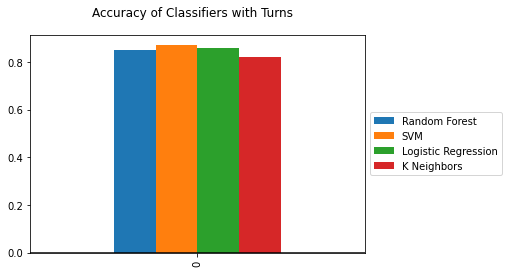

In [69]:
accuracyTurnsFrame = pd.DataFrame({
    'Random Forest': cvRandomForestT_result["Accuracy"],
    'SVM': cvsvm_resultT["Accuracy"],
    'Logistic Regression': cvLRCT_result['Accuracy'],
    'K Neighbors': cvKNT_result['Accuracy']
},index=[0])

accuracyTurnsFrame.plot(kind='bar')
plt.axhline(0, color='k')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.suptitle('Accuracy of Classifiers with Turns')

Text(0.5, 0.98, 'Precision of Classifiers with Turns')

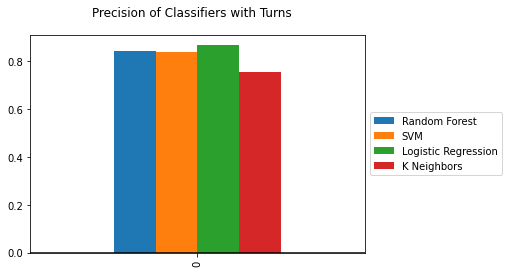

In [70]:
precisionTurnsFrame = pd.DataFrame({
    'Random Forest': cvRandomForestT_result["Precision"],
    'SVM': cvsvm_resultT["Precision"],
    'Logistic Regression': cvLRCT_result['Precision'],
    'K Neighbors': cvKNT_result['Precision']
},index=[0])

precisionTurnsFrame.plot(kind='bar')
plt.axhline(0, color='k')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.suptitle('Precision of Classifiers with Turns')

Text(0.5, 0.98, 'Recall of Classifiers with Turns')

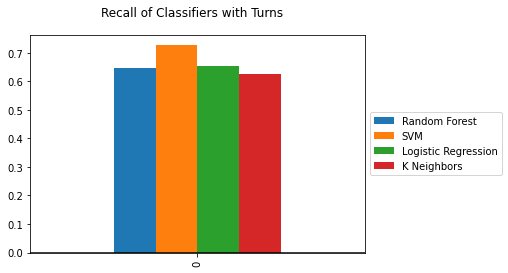

In [71]:
recallTurnsFrame = pd.DataFrame({
    'Random Forest': cvRandomForestT_result["Recall"],
    'SVM': cvsvm_resultT["Recall"],
    'Logistic Regression': cvLRCT_result['Recall'],
    'K Neighbors': cvKNT_result['Recall']
},index=[0])

recallTurnsFrame.plot(kind='bar')
plt.axhline(0, color='k')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.suptitle('Recall of Classifiers with Turns')

Text(0.5, 0.98, 'f1 of Classifiers with Turns')

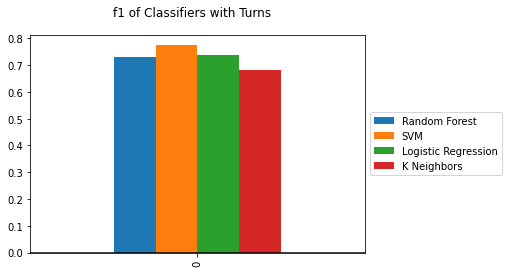

In [72]:
f1TurnsFrame = pd.DataFrame({
    'Random Forest': cvRandomForestT_result["F1 Score"],
    'SVM': cvsvm_resultT["F1 Score"],
    'Logistic Regression': cvLRCT_result['F1 Score'],
    'K Neighbors': cvKNT_result['F1 Score']
},index=[0])

f1TurnsFrame.plot(kind='bar')
plt.axhline(0, color='k')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.suptitle('f1 of Classifiers with Turns')

## Playing with HyperParameters and Turns

In [73]:
parameters = {'min_samples_split': [2, 3, 4, 5, 6]}
clf = GridSearchCV(RandomForestClassifier(oob_score=True),parameters)
clf.fit(XwithTurnst, ywithTurnst)
best_params = clf.best_params_

best_RandomForestT_Tuned = RandomForestClassifier(min_samples_split=best_params['min_samples_split'], oob_score=True)
best_RandomForestT_Tuned.fit(XwithTurnst, ywithTurnst)

best_RandomForestT_TunedPred = best_RandomForestT_Tuned.predict(XwithTurnsv)

printScoresInSampleRun(ywithTurnsv, best_RandomForestT_TunedPred, best_RandomForestT_Tuned, XwithTurnsv)
print('OOB Error :', np.round(1 - best_RandomForestT_Tuned.oob_score_, 4))

cvRandomForestT_Tuned = cross_validate(best_RandomForestT_Tuned, XwithTurns, y, scoring=scoringRandomForest, cv=fold)
cvRandomForestT_Tuned_result = pd.DataFrame({
    'Model': 'RandomForestClassifierTurnsTuned',
    'Accuracy': np.round(cvRandomForestT_Tuned['test_accuracy'].mean(), 4),
    'Precision': np.round(cvRandomForestT_Tuned['test_precision'].mean(), 4),
    'Recall': np.round(cvRandomForestT_Tuned['test_recall'].mean(), 4),
    'F1 Score': np.round(cvRandomForestT_Tuned['test_f1 score'].mean(), 4),
    'ROC AUC': np.round(cvRandomForestT_Tuned['test_roc auc'].mean(), 4),
        'OOB Error': np.round(cvRandomForestT_Tuned['test_oob'].mean(), 4)
},index=[0])
cvRandomForestT_Tuned_result

Accuracy Score : 0.8433
Precision Score : 0.8116
Recall Score : 0.6222
F1 Score : 0.7044
AUC Score : 0.8961
OOB Error : 0.1557


,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC,OOB Error
0,RandomForestClassifierTurnsTuned,0.844,0.8243,0.6355,0.7156,0.7866,0.171


In [74]:
parameters = {'kernel':('linear', 'rbf'), 'C': [0.1, 1, 100, 1000], 'gamma': [0.0001, 0.001, 0.005, 0.1, 1, 3, 5]}
svmClassifierTurns = svm.SVC(probability=True)
clf = GridSearchCV(svmClassifierTurns, parameters)
clf.fit(XwithTurnst, ywithTurnst)

best_params = clf.best_params_

best_svmTTuned = svm.SVC(probability=True, kernel=best_params['kernel'], C=best_params["C"],gamma=best_params["gamma"])
best_svmTTuned.fit(XwithTurnst, ywithTurnst)
best_svmTPredTuned = best_svmTTuned.predict(XwithTurnsv)

printScoresInSampleRun(ywithTurnsv, best_svmTPredTuned, best_svmTTuned, XwithTurnsv)

cvSVMTTuned = cross_validate(best_svmTTuned, XwithTurns, y, scoring=scoring2, cv=fold)
cv_resultSVMTTuned = pd.DataFrame({
    'Model': 'SVCTurnTuned',
    'Accuracy': np.round(cvSVMTTuned['test_accuracy'].mean(), 4),
    'Precision': np.round(cvSVMTTuned['test_precision'].mean(), 4),
    'Recall': np.round(cvSVMTTuned['test_recall'].mean(), 4),
    'F1 Score': np.round(cvSVMTTuned['test_f1 score'].mean(), 4),
    'ROC AUC': np.round(cvSVMTTuned['test_roc auc'].mean(), 4)
},index=[0])
cv_resultSVMTTuned

Accuracy Score : 0.8633
Precision Score : 0.8101
Recall Score : 0.7111
F1 Score : 0.7574
AUC Score : 0.9324


,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,SVCTurnTuned,0.861,0.8007,0.7507,0.7695,0.8312


In [75]:
parameters = {'C': [0.1, 1, 100, 1000], 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}
logisticRegressionClassifierT = GridSearchCV(LogisticRegression(max_iter = 10000), parameters)
logisticRegressionClassifierT.fit(XwithTurnst,ywithTurnst)
best_params = logisticRegressionClassifierT.best_params_

best_lrcT_Tuned = LogisticRegression(C = best_params['C'], solver = best_params['solver'], max_iter = 10000)
best_lrcT_Tuned.fit(XwithTurnst, ywithTurnst)

best_lrcT_TunedPred = best_lrcT_Tuned.predict(XwithTurnsv)

printScoresInSampleRun(ywithTurnsv, best_lrcT_TunedPred, best_lrcT_Tuned, XwithTurnsv)

cvLRCT = cross_validate(best_lrcT_Tuned, XwithTurns, y, scoring=scoring2, cv=fold)
cvLRCT_resultTuned = pd.DataFrame({
    'Model': 'LogisticRegressionTurnsTuned',
    'Accuracy': np.round(cvLRCT['test_accuracy'].mean(), 4),
    'Precision': np.round(cvLRCT['test_precision'].mean(), 4),
    'Recall': np.round(cvLRCT['test_recall'].mean(), 4),
    'F1 Score': np.round(cvLRCT['test_f1 score'].mean(), 4),
    'ROC AUC': np.round(cvLRCT['test_roc auc'].mean(), 4)
},index=[0])
cvLRCT_resultTuned

Accuracy Score : 0.8567
Precision Score : 0.7831
Recall Score : 0.7222
F1 Score : 0.7514
AUC Score : 0.9289


,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,LogisticRegressionTurnsTuned,0.854,0.7806,0.7529,0.7614,0.8264


In [76]:
parameters = {'n_neighbors': [1, 2, 3, 4, 5, 10, 15], 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}
kNeighborsClassifierClassifierT = GridSearchCV(KNeighborsClassifier(), parameters)
kNeighborsClassifierClassifierT.fit(XwithTurnst, ywithTurnst)
best_params = kNeighborsClassifierClassifierT.best_params_

best_kNSTTuned = KNeighborsClassifier(n_neighbors = best_params['n_neighbors'], algorithm = best_params['algorithm'])
best_kNSTTuned.fit(XwithTurnst, ywithTurnst)

best_kNSTTunedPred = best_kNSTTuned.predict(XwithTurnsv)

printScoresInSampleRun(ywithTurnsv, best_kNSTTunedPred, best_kNSTTuned, XwithTurnsv)

cvkNT = cross_validate(best_kNSTTuned, XwithTurns, y, scoring=scoring2, cv=fold)
cvkNT_resultTuned = pd.DataFrame({
    'Model': 'K-NeighborsTurnsTuned',
    'Accuracy': np.round(cvkNT['test_accuracy'].mean(), 4),
    'Precision': np.round(cvkNT['test_precision'].mean(), 4),
    'Recall': np.round(cvkNT['test_recall'].mean(), 4),
    'F1 Score': np.round(cvkNT['test_f1 score'].mean(), 4),
    'ROC AUC': np.round(cvkNT['test_roc auc'].mean(), 4)
},index=[0])
cvkNT_resultTuned

Accuracy Score : 0.8233
Precision Score : 0.8033
Recall Score : 0.5444
F1 Score : 0.649
AUC Score : 0.8966


,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,K-NeighborsTurnsTuned,0.816,0.8026,0.5488,0.6488,0.7432


Text(0.5, 0.98, 'Accuracy of Classifiers with Turns Tuned')

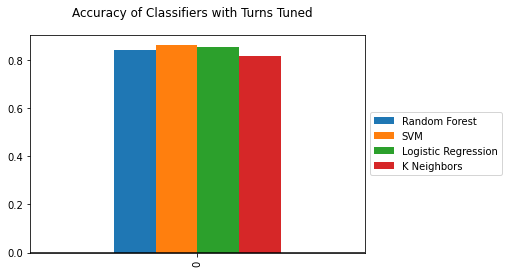

In [77]:
accuracyTurnsFrame = pd.DataFrame({
    'Random Forest': cvRandomForestT_Tuned_result["Accuracy"],
    'SVM': cv_resultSVMTTuned["Accuracy"],
    'Logistic Regression': cvLRCT_resultTuned['Accuracy'],
    'K Neighbors': cvkNT_resultTuned['Accuracy']
},index=[0])

accuracyTurnsFrame.plot(kind='bar')
plt.axhline(0, color='k')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.suptitle('Accuracy of Classifiers with Turns Tuned')

Text(0.5, 0.98, 'Precision of Classifiers with Turns Tuned')

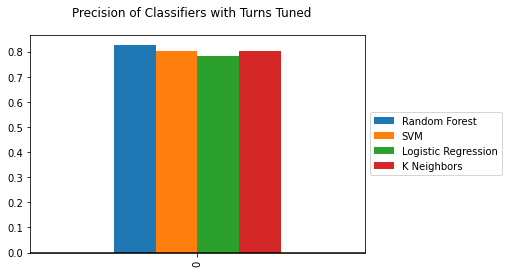

In [78]:
precisionTurnsFrame = pd.DataFrame({
    'Random Forest': cvRandomForestT_Tuned_result["Precision"],
    'SVM': cv_resultSVMTTuned["Precision"],
    'Logistic Regression': cvLRCT_resultTuned['Precision'],
    'K Neighbors': cvkNT_resultTuned['Precision']
},index=[0])

precisionTurnsFrame.plot(kind='bar')
plt.axhline(0, color='k')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.suptitle('Precision of Classifiers with Turns Tuned')

Text(0.5, 0.98, 'Recall of Classifiers with Turns Tuned')

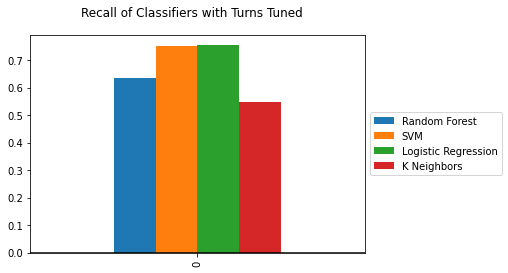

In [79]:
recallTurnsFrame = pd.DataFrame({
    'Random Forest': cvRandomForestT_Tuned_result["Recall"],
    'SVM': cv_resultSVMTTuned["Recall"],
    'Logistic Regression': cvLRCT_resultTuned['Recall'],
    'K Neighbors': cvkNT_resultTuned['Recall']
},index=[0])

recallTurnsFrame.plot(kind='bar')
plt.axhline(0, color='k')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.suptitle('Recall of Classifiers with Turns Tuned')

Text(0.5, 0.98, 'f1 of Classifiers with Turns Tuned')

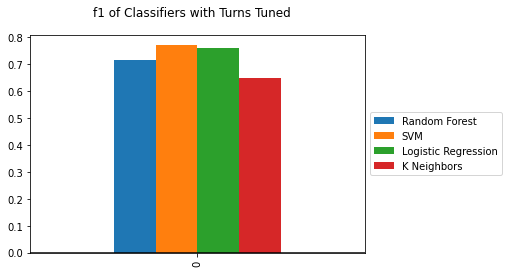

In [80]:
f1TurnsFrame = pd.DataFrame({
    'Random Forest': cvRandomForestT_Tuned_result["F1 Score"],
    'SVM': cv_resultSVMTTuned["F1 Score"],
    'Logistic Regression': cvLRCT_resultTuned['F1 Score'],
    'K Neighbors': cvkNT_resultTuned['F1 Score']
},index=[0])

f1TurnsFrame.plot(kind='bar')
plt.axhline(0, color='k')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.suptitle('f1 of Classifiers with Turns Tuned')

## Results
Based on my findings, I can conclude that adding turns would improve the performance more than if you were to add both turns and stops. I have not found any combinations of hyperparameters that would serve to improve the best model's predictions at this time. 

# Discussion
For the feature extraction, we can't really get around going through each file and extracting the data to form new features and then I'd sort them since I used glob to get the files. That takes O(nlogn * x) where n is the number of files or in our case 1000 and x being the number of rows. Creating the dataframes to hold all of them takes O(n * x) space. Now when I iterate over the dataframes, I do create three lists to hold past speeds, possible turn events and a buffer of what transpired in terms of changes in heading in 3 seconds. Timewise, it takes O(n * x) to process turns and stops. Spacewise, to get turns we take the mean of recorded speeds within three seconds. Assuming, that the average recording amortizes to being 1 second apart, the space complexity is constant or O(1). Turns are trickier as a turn could take longer than 3 seconds. Worst case, a vehicle could be perpetually turning. It may also never turn at all. It will be bounded by n however. 

Strictly speaking, if I'm concerned with accuracy, then I should just focus on SVM's and augment the data matrix with turns. The accuracy of our SVC with turns added is .869, the precision is .8378, the recall is .7235. I determined that SVM's were the best choice based on the F1 score and accuracy across all my experiments.

If I were to try and make current results better, I would try removing some features in the original dataset to see if they might be generating noise, I would also have tried building out a neural network but I couldn't after spending a significant amount of time attempting that. (I had issues with Pytorch).



### Unusual Notable Events 
I did take a look at unusual results where I found 0 stops and turns. For example, originally I came up with a naive solution to get stops but I found 0195 had a single 0 at the end which is just unusual. That's when I decided to use the mean. In addition, some files like 0900 had time intervals that weren't exactly evenly spaced out so I truncated the times. There was a file 0352 where it seemed like it would have stops but I looked closer and the speeds of 0's were all at times that were considerable distances away so it could be discarded.

# Generating Predictions

In [81]:
cvsvm_resultT

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,SVCTurns,0.869,0.8378,0.7257,0.7735,0.8304


In [82]:
localdirRootTest = '/home/aaron/Documents/Coding/RootDataScienceWork/'
testFiles = sorted(glob.glob(localdirRoot + 'work_sample/work_sample_test_trips/' + "/*.csv"))
dataFramesTest = [pd.read_csv(file) for file in testFiles]
stopsTurnsTest = [(0,0) for i in range(len(testFiles))]
index = 0
t = False
for df in dataFramesTest:
    df.dropna(how='any', inplace=True)
    stops, turns = getStopsAndTurns(df)
    stopsTurnsTest[index] = (stops, turns)
    index += 1

In [83]:
testFeaturesDF = pd.read_csv("./model_data_test.csv")

In [84]:
Xtest = testFeaturesDF.iloc[:,1:]
Xtest['Turns'] = [turn[1] for turn in stopsTurnsTest]
mmsTest = MinMaxScaler()

Xtest = mms.fit_transform(Xtest)

In [85]:
submission = svmClassifierT.predict(Xtest)

In [86]:
submission

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [87]:
import csv

with open('submission.csv', mode='w') as csv_file:
    prediction_writer = csv.writer(csv_file)
    for i in range(len(submission)):
        prediction_writer.writerow([str(1000 + i) + ".csv", submission[i]])